In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in CSV file & convert to dataframe
csv_data = pd.read_csv("Datensatz_Lichtensteiger_(FS23).csv", parse_dates=['Zeitstempel'])
data = pd.DataFrame(csv_data)

In [2]:
#show the first 10 rows of the dataframe
# data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255502 entries, 0 to 255501
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Zeitstempel                  255502 non-null  datetime64[ns]
 1   BonNr                        255502 non-null  object        
 2   Filiale                      255502 non-null  object        
 3   KundenKarte                  4821 non-null    object        
 4   Mwst Satz                    255502 non-null  float64       
 5   Menge                        255502 non-null  float64       
 6   Preis                        255502 non-null  float64       
 7   ArtikelNr                    255502 non-null  int64         
 8   Artikel                      255502 non-null  object        
 9   Umsatz                       255502 non-null  float64       
 10  Temperatur                   242804 non-null  float64       
 11  Niederschlag              

In [3]:
alle_artikel = data['Artikel'].unique()

# Data Cleaning
### KundenKarte: viele NaN's
Neue Spalte geschaffen
### Spalten mit Wetterdaten (Niederschlag, Temperatur, Globalstrahlung)
Daten pro Buchung nicht verwendet
### NaN's in Wetterdaten pro Tag
Anteil berechnet, NaN's Spalten nicht verwendet
### Extremwerte
Einige Bestellungen sehr gross. Daher Buchungen die grösser als 1.5 * dem durschnittlichen tägliche Umsatz eines Produktes sind herausgefiltert.

In [4]:
# create new column based on whether the value is null or not in KundenKarte
data['KundenKarte_ind'] = np.where(data['KundenKarte'].isna(), 0, 1)

# drop columns: KundenKarte, Temperatur, Niederschlag, Globalstrahlung, ArtikelNr (doppelt)
data_clean = data.drop(['KundenKarte', 'Temperatur', 'Niederschlag', 'Globalstrahlung'], axis=1)

# calculate proportion of missing values in Wetterdaten
print(data_clean['Temperatur Schnitt Tag'].isnull().mean())
print(data_clean['Niederschlag Summe Tag'].isnull().mean())
print(data_clean['Globalstrahlung Schnitt Tag'].isnull().mean())

# drop rows with missing values in Wetterdaten
data_clean = data_clean.dropna()
data_clean.info()

0.02306439871312162
0.0
0.022262056657090745
<class 'pandas.core.frame.DataFrame'>
Int64Index: 249609 entries, 0 to 255501
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Zeitstempel                  249609 non-null  datetime64[ns]
 1   BonNr                        249609 non-null  object        
 2   Filiale                      249609 non-null  object        
 3   Mwst Satz                    249609 non-null  float64       
 4   Menge                        249609 non-null  float64       
 5   Preis                        249609 non-null  float64       
 6   ArtikelNr                    249609 non-null  int64         
 7   Artikel                      249609 non-null  object        
 8   Umsatz                       249609 non-null  float64       
 9   Temperatur Schnitt Tag       249609 non-null  float64       
 10  Niederschlag Summe Tag       249609 non-null  f

In [5]:
data_clean.groupby(['Artikel', 'ArtikelNr'])['Menge'].sum()


Artikel                                          ArtikelNr
Berliner m Confi Himbeer of                      521          10995.0
Butter-Gipfel / Croissant of                     380          96873.0
Butterzopf       440   2-teilig                  131           5605.0
Erdbeertörtli gross                              672           4393.0
Gallusbrot 400   of                              97           15450.0
Körnergipfel of                                  385          17258.0
Laugen-Gipfel          of                        357          26872.0
Mais-Brötli süss   of                            325           9975.0
Mais-Gipfel of                                   383          13820.0
Nuss-Stengel Original                            483           9107.0
Pain Roule rustico klein  of                     320          16249.0
Semmel                 of                        299          12093.0
Sonnenblumenbrötli  of                           342           9266.0
St. Galler Handb dk. Culinarium

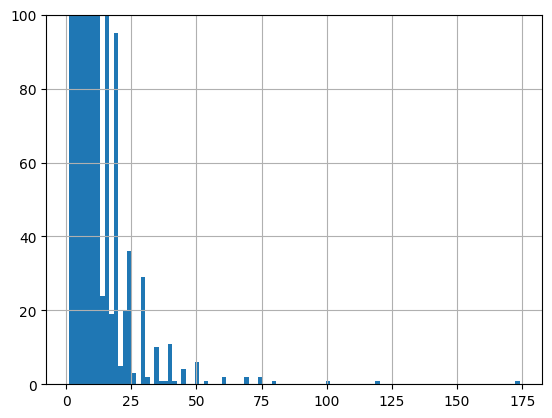

In [6]:
# histogram with the distribution of the Menge values, cut off at y-axis at 100
data_clean['Menge'].hist(bins=100)
plt.ylim(0, 100)
plt.show()

# Mutate Zeitstempel to only contain date
data_clean['Zeitstempel_date'] = data_clean['Zeitstempel'].dt.date

# Aggregate Dataset by Artikel, Mwst Satz und Zeitstempel and sum up the Menge
menge_day = data_clean.groupby(['Artikel', 'Zeitstempel_date'])['Menge'].sum().reset_index()

# Calculate mean Menge per Artikel per day
mean_daily_rev = menge_day.groupby(['Artikel'])['Menge'].mean().reset_index()

# rename Menge to Menge_mean
mean_daily_rev = mean_daily_rev.rename(columns={'Menge': 'Menge_mean'})

# merge mean_daily_rev with data_clean to filter_dataset
filter_dataset = pd.merge(data_clean, mean_daily_rev, on='Artikel', how='left')

# find all rows where the Menge sold is higher than the average daily sold Menge * 1.5
filter_dataset[filter_dataset['Menge'] > filter_dataset['Menge_mean'] * 1.5]

# create new data_clean_2 with only the rows where the Menge sold is higher than the average daily sold Menge * 1.5
data_clean_2 = filter_dataset[filter_dataset['Menge'] < filter_dataset['Menge_mean'] * 1.5]

# create new aggregated dataset with the sum of the Menge per Artikel and Zeitstempel
menge_day_clean = data_clean_2.groupby(['Artikel', 'ArtikelNr', 'Zeitstempel_date'])['Menge'].sum().reset_index()


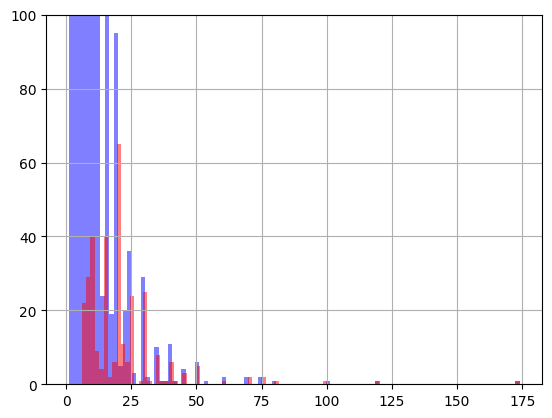

In [7]:
data_clean['Menge'].hist(bins=100, color="blue", alpha=0.5)
filter_dataset[filter_dataset['Menge'] > filter_dataset['Menge_mean'] * 1]['Menge'].hist(bins=100,  color="red", alpha=0.5)
plt.ylim(0, 100)
plt.show()

# Construct Data
## Wetterdaten hinzufügen
Die durchschnittlichen Werte von Temperatur, Niederschlag, Globalstrahlung pro Tag dem Datenset hinzufügen




In [8]:
# dataset with Wetterdaten: Temperatur, Niederschlag, Globalstrahlung (daily) from data_clean 
wetterdaten = data_clean_2[['Zeitstempel_date', 'Temperatur Schnitt Tag', 'Niederschlag Summe Tag', 'Globalstrahlung Schnitt Tag']].drop_duplicates()

# merge data_day and wetterdaten
data_weather = pd.merge(menge_day_clean, wetterdaten, on='Zeitstempel_date', how='left')

data_weather.head()

,Artikel,ArtikelNr,Zeitstempel_date,Menge,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag
0,Berliner m Confi Himbeer of,521,2018-01-02,5.0,3.800000,4.8,37.791667
1,Berliner m Confi Himbeer of,521,2018-01-03,4.0,7.200000,0.0,0.000000
2,Berliner m Confi Himbeer of,521,2018-01-04,3.0,9.216667,19.2,24.230769
3,Berliner m Confi Himbeer of,521,2018-01-05,7.0,10.600000,0.0,68.000000
4,Berliner m Confi Himbeer of,521,2018-01-08,9.0,3.411765,0.0,49.352941


## Neue Spalten: Wochentag, Tag des Jahres, Monat
Neue Spalten aufgrund der Zeitstempel Variable.

In [9]:
# format Zeitstempel_date to datetime as new column Zeitstempel
data_weather['Zeitstempel'] = pd.to_datetime(data_weather['Zeitstempel_date'])

# new columns with the day of the week, day of the year and month
data_weather['day_of_week'] = data_weather['Zeitstempel'].dt.dayofweek
data_weather['day_of_year'] = data_weather['Zeitstempel'].dt.dayofyear
data_weather['month'] = data_weather['Zeitstempel'].dt.month
data_weather['year'] = data_weather['Zeitstempel'].dt.year

# rename dataset to data_constructed
data_constructed = data_weather.drop(['Zeitstempel_date'], axis=1)

# Look at the first 5 rows of the dataset
data_constructed.head()

,Artikel,ArtikelNr,Menge,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Zeitstempel,day_of_week,day_of_year,month,year
0,Berliner m Confi Himbeer of,521,5.0,3.800000,4.8,37.791667,2018-01-02,1,2,1,2018
1,Berliner m Confi Himbeer of,521,4.0,7.200000,0.0,0.000000,2018-01-03,2,3,1,2018
2,Berliner m Confi Himbeer of,521,3.0,9.216667,19.2,24.230769,2018-01-04,3,4,1,2018
3,Berliner m Confi Himbeer of,521,7.0,10.600000,0.0,68.000000,2018-01-05,4,5,1,2018
4,Berliner m Confi Himbeer of,521,9.0,3.411765,0.0,49.352941,2018-01-08,0,8,1,2018


# Format data

## Identify skewed distributions

array([[<Axes: title={'center': 'ArtikelNr'}>,
        <Axes: title={'center': 'Menge'}>,
        <Axes: title={'center': 'Temperatur Schnitt Tag'}>],
       [<Axes: title={'center': 'Niederschlag Summe Tag'}>,
        <Axes: title={'center': 'Globalstrahlung Schnitt Tag'}>,
        <Axes: title={'center': 'Zeitstempel'}>],
       [<Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'day_of_year'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'year'}>, <Axes: >, <Axes: >]],
      dtype=object)

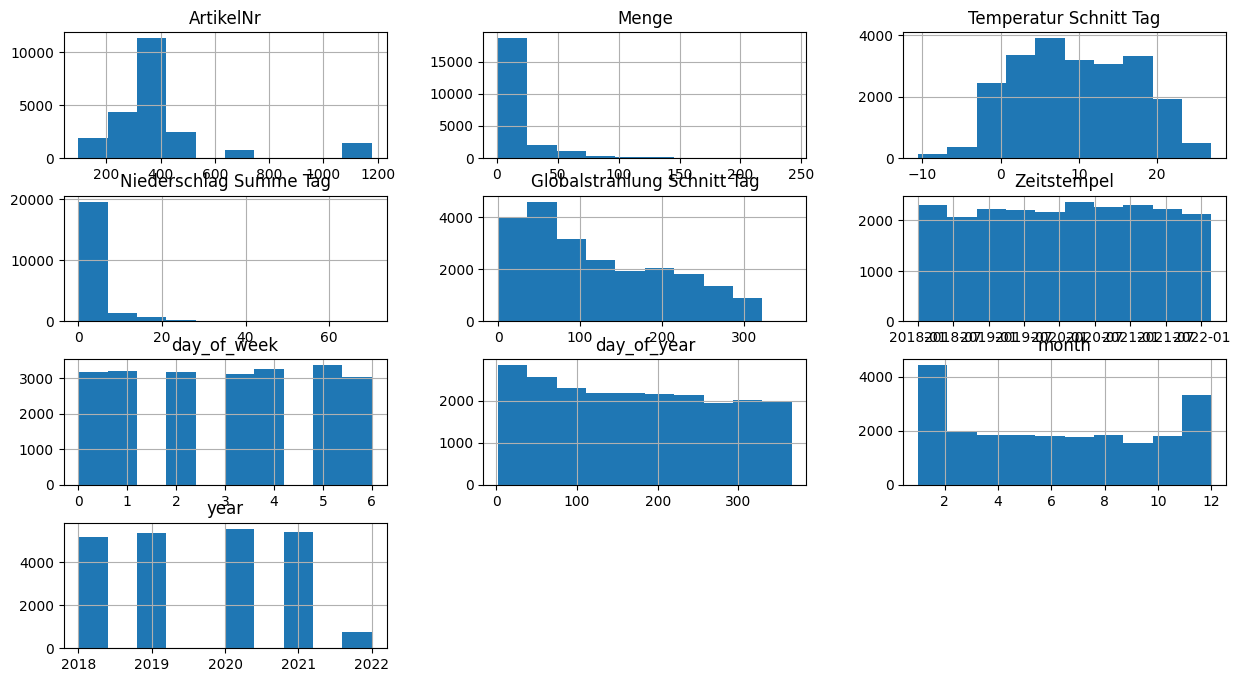

In [10]:
data_constructed.hist(figsize=(15,8))

## Logarithmize the variables

In [11]:
data_constructed['Menge_log'] = np.log(data_constructed['Menge'] + 1)

array([[<Axes: title={'center': 'ArtikelNr'}>,
        <Axes: title={'center': 'Menge'}>,
        <Axes: title={'center': 'Temperatur Schnitt Tag'}>],
       [<Axes: title={'center': 'Niederschlag Summe Tag'}>,
        <Axes: title={'center': 'Globalstrahlung Schnitt Tag'}>,
        <Axes: title={'center': 'Zeitstempel'}>],
       [<Axes: title={'center': 'day_of_week'}>,
        <Axes: title={'center': 'day_of_year'}>,
        <Axes: title={'center': 'month'}>],
       [<Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'Menge_log'}>, <Axes: >]], dtype=object)

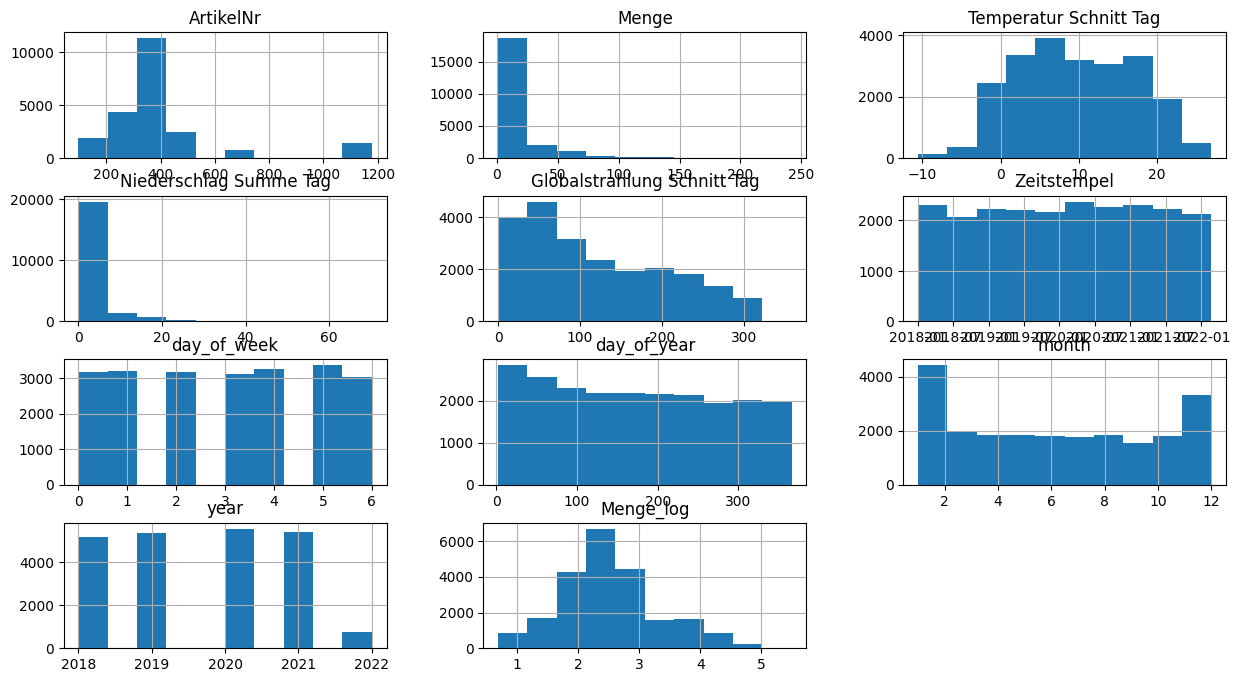

In [12]:
data_constructed.hist(figsize=(15,8))

In [13]:
# Save the dataset as a csv file
data_constructed.to_csv('data_constructed.csv', index=False)

data_constructed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22266 entries, 0 to 22265
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Artikel                      22266 non-null  object        
 1   ArtikelNr                    22266 non-null  int64         
 2   Menge                        22266 non-null  float64       
 3   Temperatur Schnitt Tag       22266 non-null  float64       
 4   Niederschlag Summe Tag       22266 non-null  float64       
 5   Globalstrahlung Schnitt Tag  22266 non-null  float64       
 6   Zeitstempel                  22266 non-null  datetime64[ns]
 7   day_of_week                  22266 non-null  int64         
 8   day_of_year                  22266 non-null  int64         
 9   month                        22266 non-null  int64         
 10  year                         22266 non-null  int64         
 11  Menge_log                    22266 non-nu

In [14]:
data_constructed.head()

,Artikel,ArtikelNr,Menge,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Zeitstempel,day_of_week,day_of_year,month,year,Menge_log
0,Berliner m Confi Himbeer of,521,5.0,3.800000,4.8,37.791667,2018-01-02,1,2,1,2018,1.791759
1,Berliner m Confi Himbeer of,521,4.0,7.200000,0.0,0.000000,2018-01-03,2,3,1,2018,1.609438
2,Berliner m Confi Himbeer of,521,3.0,9.216667,19.2,24.230769,2018-01-04,3,4,1,2018,1.386294
3,Berliner m Confi Himbeer of,521,7.0,10.600000,0.0,68.000000,2018-01-05,4,5,1,2018,2.079442
4,Berliner m Confi Himbeer of,521,9.0,3.411765,0.0,49.352941,2018-01-08,0,8,1,2018,2.302585
